<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter03/Scaling_the_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scaling a dataset to improve model accuracy
Scaling a dataset is the process of ensuring that the variables are confined to a finite range. In this section, we will confine the independent variables' values to values between 0 and 1 by dividing each input value by the maximum possible value in the dataset. This is a value of 255, which corresponds to white pixels

In [1]:
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"
import numpy as np
data_folder = '~/datasets/FMNIST' # This can be any directory you want 
# to download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets

In [2]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255    # this is where we apply the scaling
        x = x.view(-1,28*28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix] 
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

Same code as in previous notebook:

In [3]:
def get_data(): 
    train = FMNISTDataset(tr_images, tr_targets) 
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    return trn_dl
from torch.optim import SGD
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    # call your model like any python function on your batch of inputs
    prediction = model(x)
    # compute loss
    batch_loss = loss_fn(prediction, y)
    # based on the forward pass in `model(x)` compute all the gradients of 
    # 'model.parameters()'
    batch_loss.backward()
    # apply new-weights = f(old-weights, old-weight-gradients) 
    # where "f" is the optimizer
    optimizer.step()
    # Flush memory for next batch of calculations
    optimizer.zero_grad()
    return batch_loss.item()
def accuracy(x, y, model):
    model.eval()
    # since there's no need for updating weights, we might 
    # as well not compute the gradients
    with torch.no_grad():
        # get the prediction matrix for a tensor of `x` images
        prediction = model(x)
    # compute if the location of maximum in each row coincides 
    # with ground truth
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()
trn_dl = get_data()
model, loss_fn, optimizer = get_model()
losses, accuracies = [], []
for epoch in range(5):
    print(epoch)
    epoch_losses, epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

0
1
2
3
4


<ipython-input-4-dea3965dc722>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


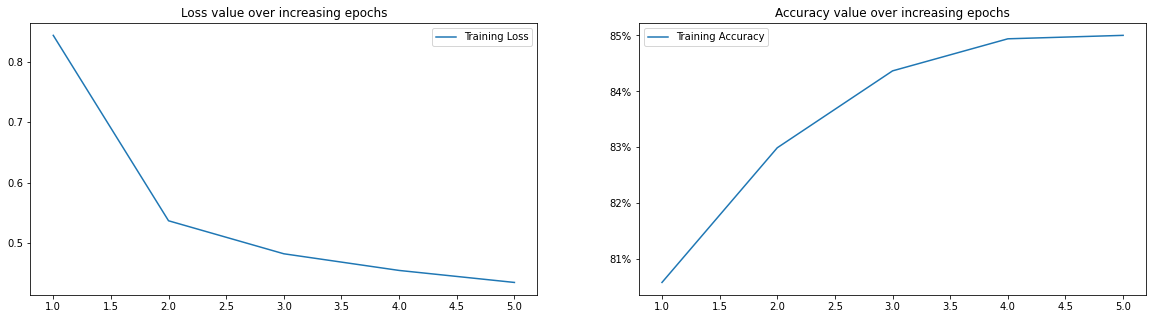

In [4]:
epochs = np.arange(5)+1
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()

note that the results are much better. the scaling helped a great deal !! 
lets try with 50 epochs

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


<ipython-input-5-1142c9626b8c>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


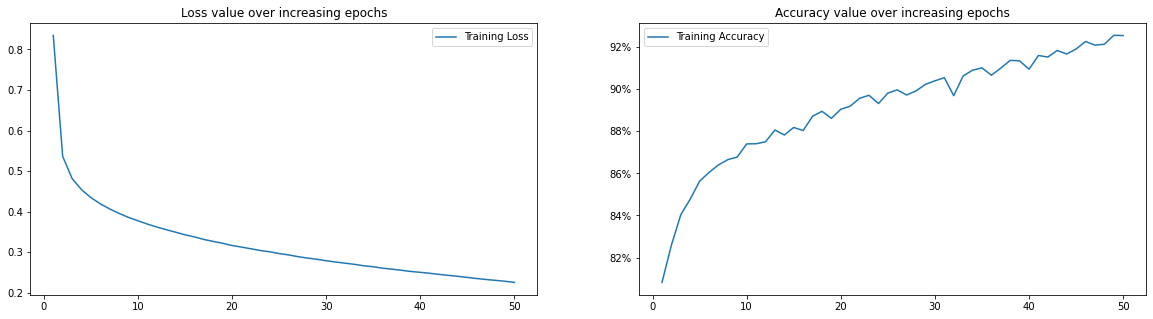

In [5]:
n_epochs=50
trn_dl = get_data()
model, loss_fn, optimizer = get_model()
losses, accuracies = [], []
for epoch in range(n_epochs):
    print(epoch)
    epoch_losses, epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

epochs = np.arange(n_epochs)+1
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()

and we see that the accuracy continues to grow.
so we can conclude that the scaling helped a lot.  
but why ?

Let's take the example of how a sigmoid value is calculated:

$$ sigmoid = \frac{1}{(1+e^{-input \cdot weight})} $$

lets calculate the Sigmoid based on this formula in 2 cases: input is scaled and not scaled

In [17]:
w=np.array([10**x for x in range(-5,0)])
w=np.concatenate([w,np.arange(0.2,1,0.1)])
# unscaled 
input=255
sigm=1/(1+np.exp(-input*w))
print (sigm)

#scaled
input=1
sigm=1/(1+np.exp(-input*w))
print (sigm)



[0.5006375  0.50637465 0.56340679 0.92757351 1.         1.
 1.         1.         1.         1.         1.         1.
 1.        ]
[0.5000025  0.500025   0.50025    0.50249998 0.52497919 0.549834
 0.57444252 0.59868766 0.62245933 0.64565631 0.66818777 0.68997448
 0.7109495 ]


In the left-hand table, we can see that when the weight values are more than 0.1, the Sigmoid value does not vary with an increasing (changing) weight value. Furthermore, the Sigmoid value changed only by a little when the weight was extremely small; the only way to vary the sigmoid value is by having the weight change to a very, very small amount.  
However, the Sigmoid value changed considerably in the right-hand table when the input value was small.  
The reason for this is that the exponential of a large negative value (resulting from multiplying the weight value by a large number) is very close to 0, while the exponential value varies when the weight is multiplied by a scaled input, as seen in the right-hand table.  
Now that we have understood that the Sigmoid value does not change considerably unless the weight values are very small, we will now learn about how weight values can be influenced toward an optimal value.  

**Tip**  
Scaling the input dataset so that it contains a much smaller range of values generally helps in achieving better model accuracy

Next we'll understand another important parameter : batch_size (see [Varying_batch_size.ipynb](./Varying_batch_size.ipynb))